In [1]:
import sys

sys.path.insert(0, "../")
import regridcart as rc

import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
target_domain = rc.LocalCartesianDomain(
    central_latitude=14.0,
    central_longitude=-48,
    l_meridional=1000.0e3,
    l_zonal=3000.0e3,
)

<IPython.core.display.Javascript object>

<GeoAxesSubplot:>

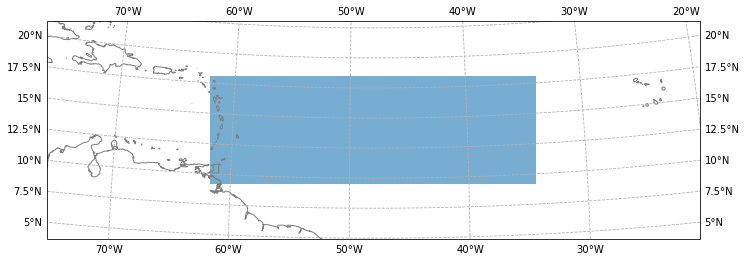

<IPython.core.display.Javascript object>

In [4]:
target_domain.plot_outline()

# Data on grid aligned with lat/lon coordinates

In [14]:
"""
Test cropping and resampling of data with x- and y-coordinates given by
longitude and latitude values respecively (i.e. the underlying grid
coordinates follow the latitude and longitude directions)
"""

# TODO: add test to ensure the resampling values are correct instead of
# just ensuring that no exceptions are raised
dlat, dlon = 0.1, 0.1
lat_span = [5.0, 20.0]
lon_span = [-70.0, -30.0]
extent = lon_span + lat_span  # for plotting later

lat0 = 0.5 * (lat_span[0] + lat_span[1])
lon0 = 0.5 * (lon_span[0] + lon_span[1])

lats = np.arange(*lat_span, dlat)
lons = np.arange(*lon_span, dlon)

ds = xr.Dataset(coords=dict(lat=lats, lon=lons))

# make a field to interpolate
ds["phi"] = np.sin(ds.lat) * np.cos(ds.lon)
ds.phi

<xarray.DataArray 'phi' (lat: 150, lon: 400)>
array([[-0.60730516, -0.6783578 , -0.74263251, ..., -0.42129892,
        -0.33319576, -0.24176342],
       [-0.58633622, -0.65493556, -0.716991  , ..., -0.40675237,
        -0.32169123, -0.23341585],
       [-0.5595088 , -0.62496943, -0.68418556, ..., -0.38814169,
        -0.30697246, -0.22273606],
       ...,
       [ 0.47598588,  0.53167461,  0.58205102, ...,  0.33020028,
         0.26114792,  0.18948624],
       [ 0.5153152 ,  0.57560533,  0.6301442 , ...,  0.35748377,
         0.28272581,  0.20514294],
       [ 0.54949567,  0.61378479,  0.67194118, ...,  0.3811954 ,
         0.3014788 ,  0.21874992]])
Coordinates:
  * lat      (lat) float64 5.0 5.1 5.2 5.3 5.4 5.5 ... 19.5 19.6 19.7 19.8 19.9
  * lon      (lon) float64 -70.0 -69.9 -69.8 -69.7 ... -30.4 -30.3 -30.2 -30.1

<IPython.core.display.Javascript object>

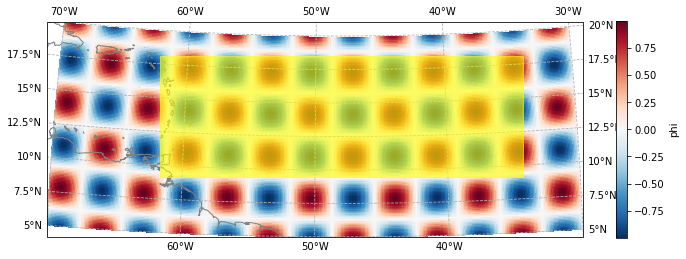

<IPython.core.display.Javascript object>

In [17]:
ax = target_domain.plot_outline(color="yellow", zorder=10)
ds.phi.plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

/Volumes/agile/tooling/miniconda3/envs/regridcart/lib/python3.7/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


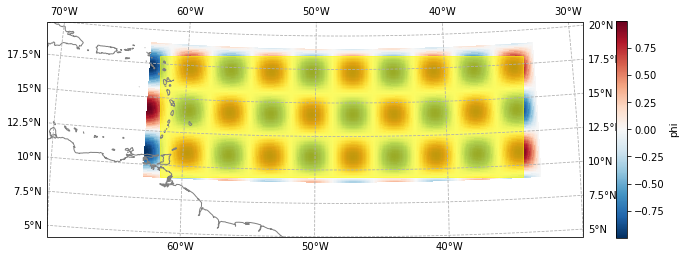

<IPython.core.display.Javascript object>

In [16]:
da_phi = ds.phi
da_phi_cropped = rc.crop_field_to_domain(domain=target_domain, da=da_phi, pad_pct=0.0)

ax = target_domain.plot_outline(color="yellow")
da_phi_cropped.plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

In [19]:
dx = 50.0e3  # [m]
da_phi_resampled = rc.resample(target_domain, da=da_phi_cropped, dx=dx)
da_phi_resampled

/Volumes/agile/tooling/miniconda3/envs/regridcart/lib/python3.7/site-packages/xesmf/smm.py:129: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


<xarray.DataArray (y: 20, x: 60)>
array([[ 0.01268515, -0.01155299, -0.01429116, ..., -0.01333286,
        -0.03955194, -0.06687458],
       [-0.07783706,  0.09627814,  0.26811794, ...,  0.26158693,
         0.35789337,  0.37190235],
       [-0.16901191,  0.16956485,  0.48631523, ...,  0.49690607,
         0.69056567,  0.73620671],
       ...,
       [-0.55828176, -0.14722886,  0.30234101, ...,  0.84947335,
         0.9617872 ,  0.86155598],
       [-0.60335961, -0.18052249,  0.27742118, ...,  0.87230403,
         0.98219749,  0.87762891],
       [-0.52603182, -0.1744809 ,  0.20182053, ...,  0.71965457,
         0.81044468,  0.72116775]])
Coordinates:
    lon      (y, x) float64 -61.45 -60.99 -60.54 -60.08 ... -35.0 -34.52 -34.05
    lat      (y, x) float64 9.358 9.381 9.403 9.425 ... 17.96 17.93 17.9 17.87
  * x        (x) float64 -1.475e+06 -1.425e+06 ... 1.425e+06 1.475e+06
  * y        (y) float64 -4.75e+05 -4.25e+05 -3.75e+05 ... 4.25e+05 4.75e+05
Attributes:
    regrid_method:  bilinear

<IPython.core.display.Javascript object>

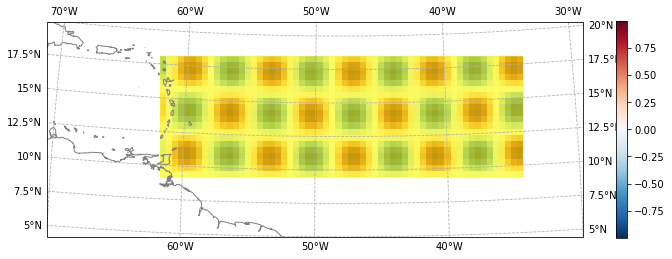

<IPython.core.display.Javascript object>

In [21]:
ax = target_domain.plot_outline(color="yellow")
da_phi_resampled.plot(ax=ax, transform=target_domain.crs)
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Data on grid with lat/lon given as auxilliary variables

In [28]:
# generate some sample data on a regular lat/lon grid
ds = xr.Dataset(coords=dict(x=np.arange(-20, 20), y=np.arange(-10, 10)))

# the lat/lon coords will be simply given as rotations here
theta = 20.0 * 3.14 / 180.0
ds.coords["lon"] = np.cos(theta) * ds.x - np.sin(theta) * ds.y - 50.0
ds.coords["lat"] = np.sin(theta) * ds.x + np.cos(theta) * ds.y + lat0

ds["phi"] = np.cos(ds.x / 4.0) * np.sin(ds.y)
ds

<xarray.Dataset>
Dimensions:  (x: 40, y: 20)
Coordinates:
  * x        (x) int64 -20 -19 -18 -17 -16 -15 -14 -13 ... 13 14 15 16 17 18 19
  * y        (y) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9
    lon      (x, y) float64 -65.38 -65.72 -66.06 -66.4 ... -34.54 -34.88 -35.22
    lat      (x, y) float64 -3.735 -2.795 -1.855 -0.9153 ... 25.57 26.51 27.45
Data variables:
    phi      (x, y) float64 0.1543 -0.1169 -0.2806 ... 0.0247 0.0372 0.0155

<IPython.core.display.Javascript object>

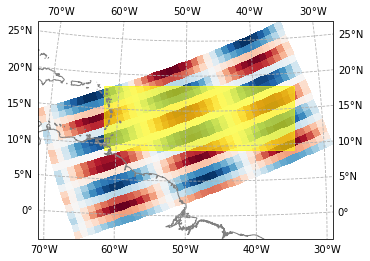

<IPython.core.display.Javascript object>

In [29]:
ax = target_domain.plot_outline(color="yellow")
ax.pcolormesh(ds.lon, ds.lat, ds.phi, transform=ccrs.PlateCarree(), cmap="RdBu_r")

In [30]:
da_phi = ds.phi
da_phi_cropped = rc.crop_field_to_domain(domain=target_domain, da=da_phi, pad_pct=0.0)

ax = domain.plot_outline(color="yellow")
da_phi_cropped.plot(ax=ax, transform=ccrs.PlateCarree())

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<IPython.core.display.Javascript object>